# An advanced coil

Resolve the current path along the wire.

Computing the magnetic field induced by a wire coil

* first, we solve an electric conductivity problem in the wire
* then, we use the computed current to solve (a reduced) Maxwell equation

In [1]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw

## model of the coil:

In [2]:
cyl = Cylinder((0,0,0), Z, r=0.01, h=0.03).faces[0]
heli = Edge(Segment((0,0), (12*pi, 0.03)), cyl)
ps = heli.start
vs = heli.start_tangent
pe = heli.end
ve = heli.end_tangent

e1 = Segment((0,0,-0.03), (0,0,-0.01))
c1 = BezierCurve( [(0,0,-0.01), (0,0,0), ps-vs, ps])
e2 = Segment((0,0,0.04), (0,0,0.06))
c2 = BezierCurve( [pe, pe+ve, (0,0,0.03), (0,0,0.04)])
spiral = Wire([e1, c1, heli, c2, e2])
circ = Face(Wire([Circle((0,0,-0.03), Z, 0.001)]))
coil = Pipe(spiral, circ)

coil.faces.maxh=0.2
coil.faces.name="coilbnd"
coil.faces.Max(Z).name="in"
coil.faces.Min(Z).name="out"
coil.faces.col=(184/256, 115/256, 51/256)
coil.mat("coil")
crosssection = coil.faces.Max(Z).mass

In [3]:
ea = { "euler_angles" : (-130, -73, 0), "radius" : 0.025 }
Draw (coil, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [4]:
box = Box((-0.04,-0.04,-0.03), (0.04,0.04,0.06))
box.faces.name = "outer"
air = box-coil
air.mat("air");

## mesh-generation of coil and air-box:

In [5]:
geo = OCCGeometry(Glue([coil,air]))
with TaskManager():
    mesh = Mesh(geo.GenerateMesh(meshsize.coarse, maxh=0.01)).Curve(3)

In [6]:
clipping = { "clipping" : { "y":1, "z":0, "dist":0.012} }
Draw (mesh, **clipping, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': (-…

checking mesh data materials and boundaries:

In [7]:
mesh.ne, mesh.nv, mesh.GetMaterials(), mesh.GetBoundaries()

(102637,
 17672,
 ('coil', 'air'),
 ('out',
  'coilbnd',
  'coilbnd',
  'coilbnd',
  'coilbnd',
  'coilbnd',
  'in',
  'outer',
  'outer',
  'outer',
  'outer',
  'outer',
  'outer'))

## Solve a potential problem to determine current density in wire:
on the domain $\Omega_{\text{coil}}$, solve for potential $\Phi$ and current density $j$:

\begin{align*}
j & = \sigma \nabla \Phi \\
\operatorname{div} j & = 0
\end{align*}
with electric conductivity $\sigma$.


port boundary conditions: 
\begin{align*}
\Phi & = 0  \qquad \qquad \text{on } \Gamma_{\text{out}},  \\
j_n & = \frac{1}{|\Gamma_{in}|} \quad \qquad \text{on } \Gamma_{\text{in}},
\end{align*}

and $j_n=0$ else

In [8]:
fespot = H1(mesh, order=3, definedon=mesh.Materials("coil"), dirichlet="out")
phi,psi = fespot.TnT()
sigma = 58.7e6
with TaskManager():
    bfa = BilinearForm(sigma*grad(phi)*grad(psi)*dx).Assemble()
    inv = bfa.mat.Inverse(freedofs=fespot.FreeDofs(), inverse="sparsecholesky")
    lff = LinearForm(1/crosssection*psi*ds("in")).Assemble()
    gfphi = GridFunction(fespot)
    gfphi.vec.data = inv * lff.vec

In [9]:
Draw (gfphi, draw_vol=False, **clipping, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': (-…

## Solve magnetostatic problem:

current source is current from potential equation: find $u \in H(\operatorname{curl})$:

$$
\int \mu^{-1} \operatorname{curl} u \cdot \operatorname{curl} v \, dx =
\int j \cdot v \, dx
$$


In [10]:
fes = HCurl(mesh, order=2, nograds=True)
print ("HCurl dofs:", fes.ndof)
u,v = fes.TnT()
mu = 4*pi*1e-7
a = BilinearForm(1/mu*curl(u)*curl(v)*dx+1e-6/mu*u*v*dx)
pre = preconditioners.BDDC(a)
f = LinearForm(sigma*grad(gfphi)*v*dx("coil"))
with TaskManager():
    a.Assemble()
    f.Assemble()

HCurl dofs: 532884


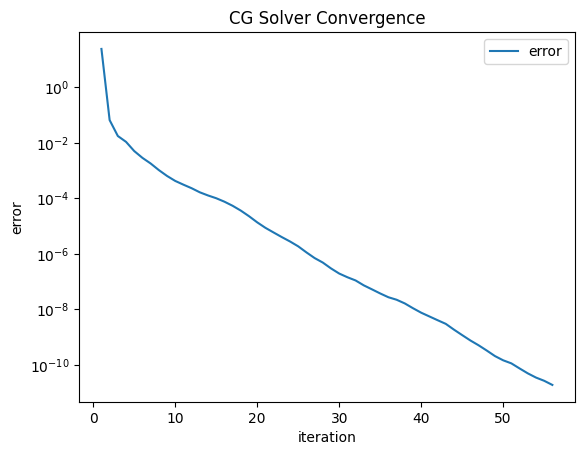

<Figure size 640x480 with 0 Axes>

In [11]:
inv = solvers.CGSolver(a.mat, pre, plotrates=True)
gfu = GridFunction(fes)
with TaskManager():
    gfu.vec.data = inv * f.vec

In [12]:
s = 0.04*2
N = 15 
p = [(-s+2*s*i/N,-s+2*s*j/N,-s+2*s*k/N) for i in range(1,N) for j in range(1,N) for k in range(1,N)]
# 
fieldlines = curl(gfu)._BuildFieldLines(mesh, p, num_fieldlines=N**3//5, randomized=True, length=0.3)
from ngsolve.webgui import FieldLines
# fieldlines = FieldLines(curl(gfu), mesh.Materials(".*"), length=0.2, num_lines=100)

# fieldlines = FieldLines(curl(gfu), mesh=mesh, start_points=p, length=0.2, num_lines=100)

Draw(curl(gfu), mesh,  "X", draw_vol=False, draw_surf=True, objects=[fieldlines], \
     min=0, max=1e-4, autoscale=False, settings={"Objects": {"Surface": False}},
    **ea, **clipping);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Surface': False}…

In [13]:
Draw (curl(gfu), mesh, draw_surf=False, \
      min=0, max=3e-4, clipping = { "y":1, "z" : 0, "function":False}, vectors = { "grid_size":100}, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': (-…

## Exercise

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…